In [2]:
!pip install numpy matplotlib scipy pillow scikit-image


In [3]:
# Placeholder for loading real-world GeoTIFF file
file_path = "./data/2024-11-23-00_00_2024-11-23-23_59_DEM_COPERNICUS_30_Grayscale (1).png"

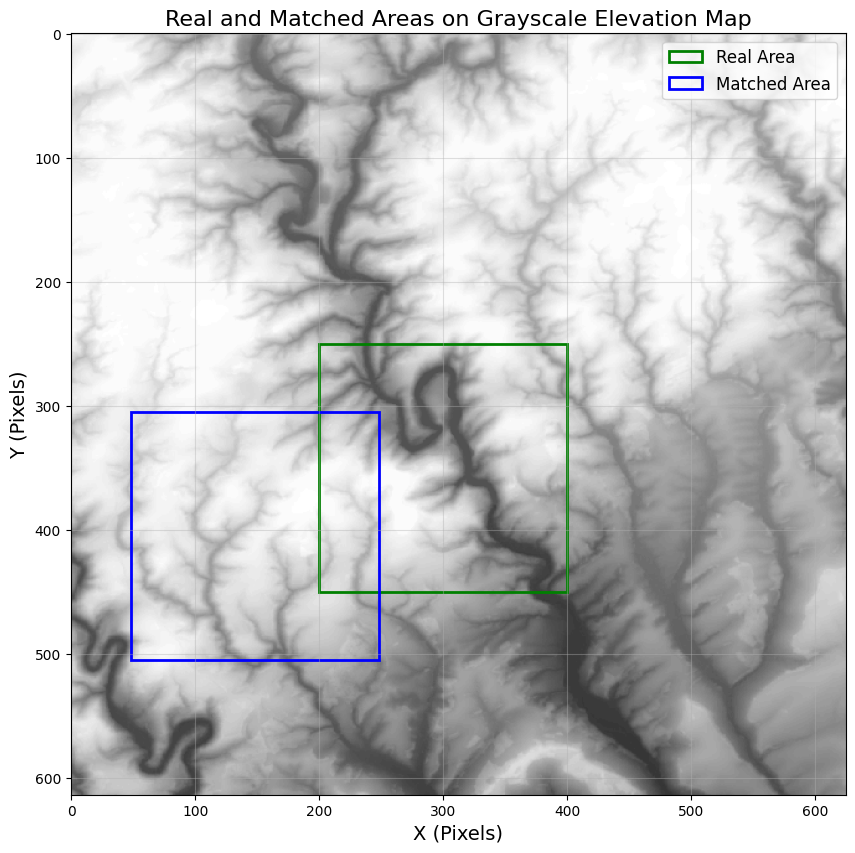

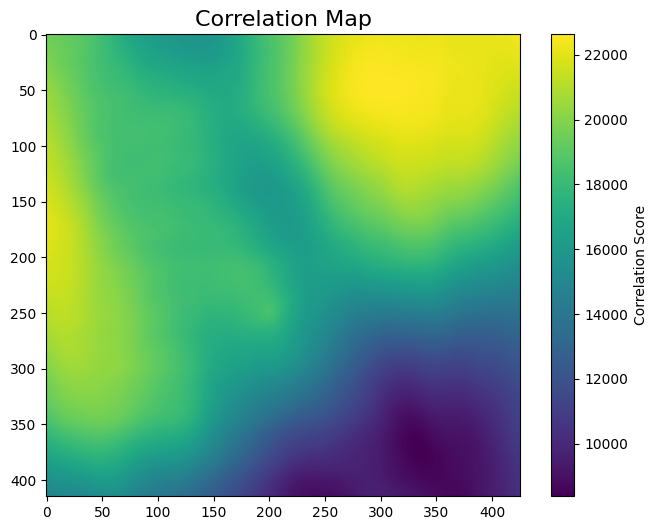

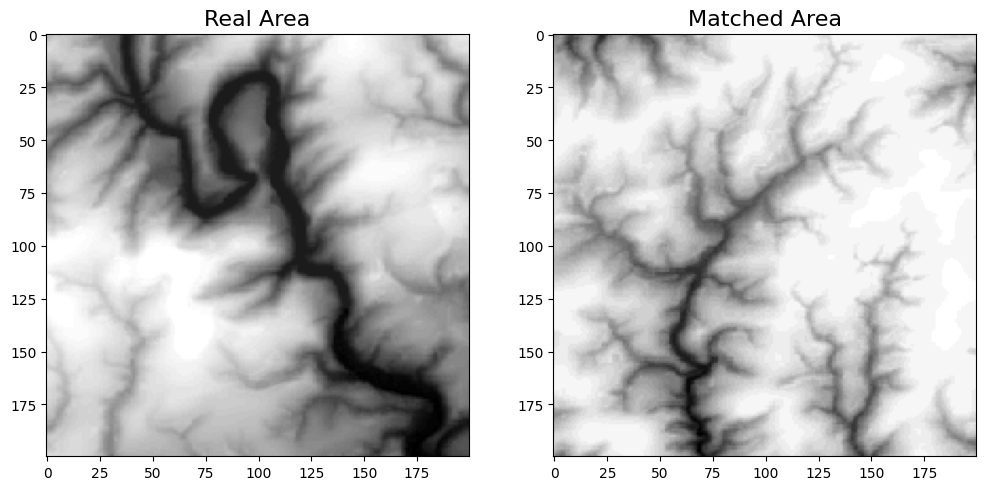

Matched Position (Pixels): (np.int64(48), np.int64(305))
Real Area Top-Left (Pixels): (250, 200)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from PIL import Image

# Load the grayscale PNG file
def load_png(file_path):
    """
    Loads a grayscale PNG image and converts it into a numpy array.
    """
    image = Image.open(file_path).convert("L")  # Convert to grayscale
    return np.array(image)

# Normalize the raster data for correlation
def normalize_raster(raster):
    """
    Normalizes raster data to the range [0, 1].
    """
    return (raster - raster.min()) / (raster.max() - raster.min())

# Clip a smaller area from the raster
def clip_raster(raster, start_x, start_y, width, height):
    """
    Clips a rectangular region from a raster.
    """
    return raster[start_y:start_y + height, start_x:start_x + width]

# Perform correlation matching with search window
def correlate_rasters(large_raster, small_raster):
    """
    Matches a small raster (observed terrain) to a larger raster using 2D correlation.
    """
    # Normalize the rasters
    large_raster_norm = normalize_raster(large_raster)
    small_raster_norm = normalize_raster(small_raster)
    
    # Perform correlation
    correlation = correlate2d(large_raster_norm, small_raster_norm, mode="valid")
    max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)
    return max_loc, correlation

# Load the PNG file
large_raster = load_png(file_path)

# Define the real area (e.g., where the drone observes)
clip_start_x, clip_start_y = 200, 250  # Starting position in pixels
clip_width, clip_height = 200, 200  # Dimensions of the clipped area
real_area = clip_raster(large_raster, clip_start_x, clip_start_y, clip_width, clip_height)

# Perform correlation matching
matched_position, correlation_map = correlate_rasters(large_raster, real_area)

# Visualize the real and matched areas
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(large_raster, cmap="gray", alpha=0.8)
ax.set_title("Real and Matched Areas on Grayscale Elevation Map", fontsize=16)

# Plot the real area
rect_real = plt.Rectangle(
    (clip_start_x, clip_start_y),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="green", facecolor="none", linewidth=2, label="Real Area"
)
ax.add_patch(rect_real)

# Plot the matched area
rect_matched = plt.Rectangle(
    (matched_position[0], matched_position[1]),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="blue", facecolor="none", linewidth=2, label="Matched Area"
)
ax.add_patch(rect_matched)

# Add legend and labels
plt.legend(fontsize=12)
ax.set_xlabel("X (Pixels)", fontsize=14)
ax.set_ylabel("Y (Pixels)", fontsize=14)
plt.grid(alpha=0.4)
plt.show()

# Plot the correlation map
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(correlation_map, cmap="viridis")
fig.colorbar(im, ax=ax, label="Correlation Score")
ax.set_title("Correlation Map", fontsize=16)
plt.show()

# Display extracted real and matched areas
matched_area = clip_raster(large_raster, matched_position[1], matched_position[0], clip_width, clip_height)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(real_area, cmap="gray")
axes[0].set_title("Real Area", fontsize=16)
axes[1].imshow(matched_area, cmap="gray")
axes[1].set_title("Matched Area", fontsize=16)
plt.show()

# Print match results
print("Matched Position (Pixels):", matched_position)
print("Real Area Top-Left (Pixels):", (clip_start_y, clip_start_x))


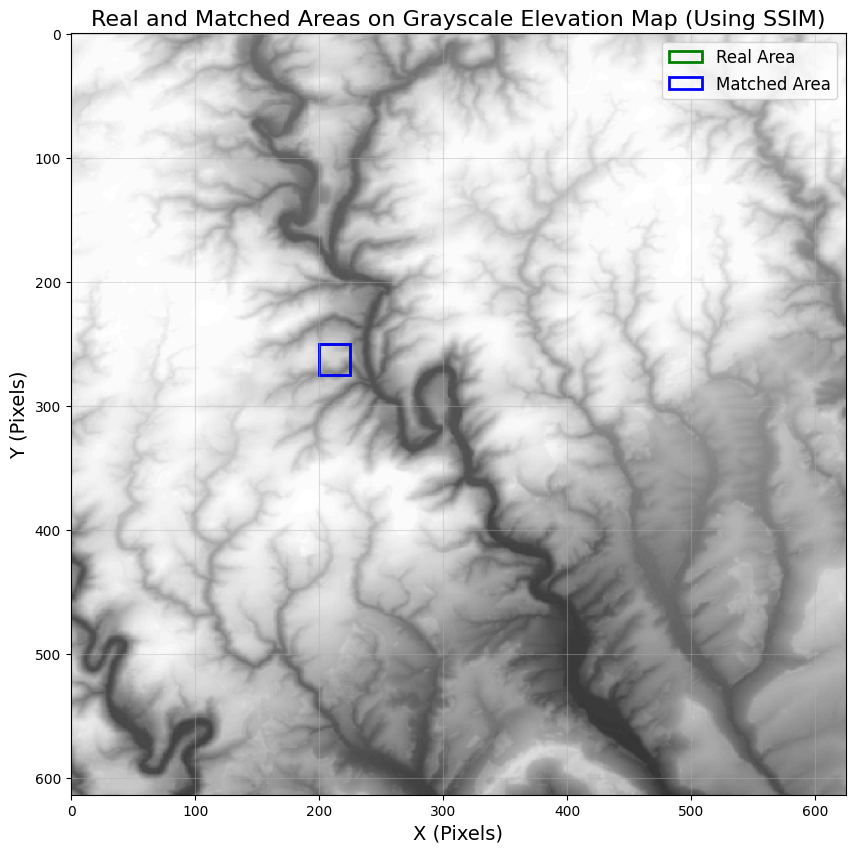

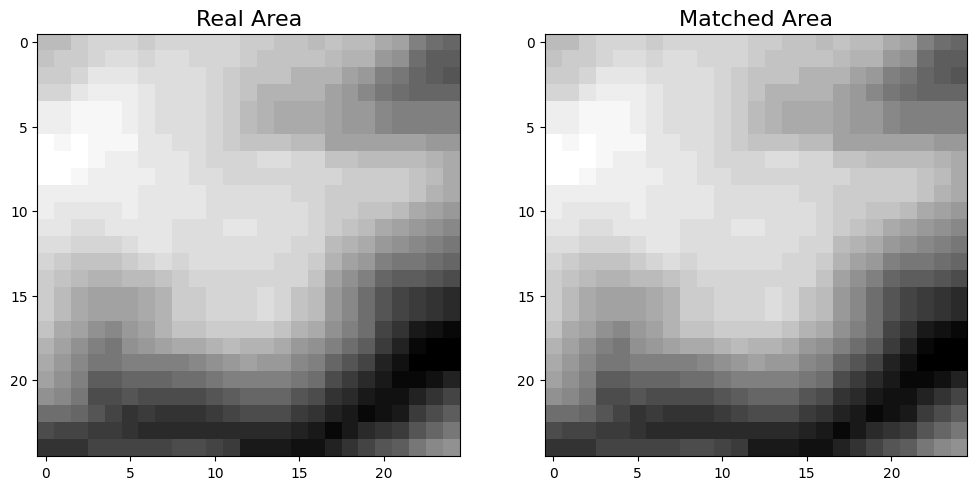

Matched Position (Pixels): (250, 200)
Best SSIM Score: 1.0
Real Area Top-Left (Pixels): (250, 200)


In [8]:
# Integration of SSIM (Structural Similarity Index) Matching into the Notebook

from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale PNG file
def load_png(file_path):
    """
    Loads a grayscale PNG image and converts it into a numpy array.
    """
    image = Image.open(file_path).convert("L")  # Convert to grayscale
    return np.array(image)

# Function to clip a smaller area from the raster
def clip_raster(raster, start_x, start_y, width, height):
    """
    Clips a rectangular region from a raster.
    """
    return raster[start_y:start_y + height, start_x:start_x + width]

from skimage.util import view_as_windows
import numpy as np

def ssim_matching_fast(large_raster, small_raster):
    """
    Optimized SSIM matching using vectorized operations.
    """
    height, width = small_raster.shape

    # Create sliding windows on the large raster
    windows = view_as_windows(large_raster, (height, width))

    # Pre-compute statistics for the small raster
    small_mean = np.mean(small_raster)
    small_std = np.std(small_raster)

    # Compute SSIM for each sliding window
    best_score = -float("inf")
    best_position = None

    for y in range(windows.shape[0]):
        for x in range(windows.shape[1]):
            patch = windows[y, x, :, :]
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)
            score = ssim(patch, small_raster, data_range=patch.max() - patch.min())
            if score > best_score:
                best_score = score
                best_position = (y, x)

    return best_position, best_score

# Downsample large raster for faster matching
def downsample_raster(raster, factor):
    """
    Downsample a raster by a given factor.
    """
    return raster[::factor, ::factor]

def multi_resolution_ssim_matching(large_raster, small_raster, downsample_factor=4):
    """
    Multi-resolution SSIM matching with downsampling and refinement.
    """
    height, width = small_raster.shape

    # Step 1: Downsample the rasters
    large_raster_ds = downsample_raster(large_raster, downsample_factor)
    small_raster_ds = downsample_raster(small_raster, downsample_factor)

    # Step 2: Perform SSIM matching on downsampled rasters
    downsampled_position, _ = ssim_matching_fast(large_raster_ds, small_raster_ds)

    # Step 3: Refine the match on full resolution
    refined_y = downsampled_position[0] * downsample_factor
    refined_x = downsampled_position[1] * downsample_factor

    # Define search region bounds
    search_window_size_y = max(height + 20, 100)  # Ensure it's larger than small_raster
    search_window_size_x = max(width + 20, 100)

    # Ensure search region stays within bounds of the large raster
    search_start_y = max(0, refined_y - search_window_size_y // 2)
    search_start_x = max(0, refined_x - search_window_size_x // 2)
    search_end_y = min(large_raster.shape[0], search_start_y + search_window_size_y)
    search_end_x = min(large_raster.shape[1], search_start_x + search_window_size_x)

    # Extract search region
    search_region = large_raster[search_start_y:search_end_y, search_start_x:search_end_x]

    # Perform refined matching in the search region
    refined_position, best_score = ssim_matching_fast(search_region, small_raster)

    # Adjust to global coordinates
    final_y = search_start_y + refined_position[0]
    final_x = search_start_x + refined_position[1]

    return (final_y, final_x), best_score



large_raster = load_png(file_path)

# Define the real area (e.g., where the drone observes)
clip_start_x, clip_start_y = 200, 250  # Starting position in pixels
clip_width, clip_height = 25, 25  # Dimensions of the clipped area
real_area = clip_raster(large_raster, clip_start_x, clip_start_y, clip_width, clip_height)

# Perform multi-resolution SSIM matching
downsample_factor = 4
matched_position, best_score = multi_resolution_ssim_matching(large_raster, real_area, downsample_factor)


# Visualize the real and matched areas
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(large_raster, cmap="gray", alpha=0.8)
ax.set_title("Real and Matched Areas on Grayscale Elevation Map (Using SSIM)", fontsize=16)

# Plot the real area
rect_real = plt.Rectangle(
    (clip_start_x, clip_start_y),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="green", facecolor="none", linewidth=2, label="Real Area"
)
ax.add_patch(rect_real)

# Plot the matched area
rect_matched = plt.Rectangle(
    (matched_position[1], matched_position[0]),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="blue", facecolor="none", linewidth=2, label="Matched Area"
)
ax.add_patch(rect_matched)

# Add legend and labels
plt.legend(fontsize=12)
ax.set_xlabel("X (Pixels)", fontsize=14)
ax.set_ylabel("Y (Pixels)", fontsize=14)
plt.grid(alpha=0.4)
plt.show()

# Display extracted real and matched areas
matched_area = clip_raster(large_raster, matched_position[1], matched_position[0], clip_width, clip_height)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(real_area, cmap="gray")
axes[0].set_title("Real Area", fontsize=16)
axes[1].imshow(matched_area, cmap="gray")
axes[1].set_title("Matched Area", fontsize=16)
plt.show()

# Print match results
print("Matched Position (Pixels):", matched_position)
print("Best SSIM Score:", best_score)
print("Real Area Top-Left (Pixels):", (clip_start_y, clip_start_x))


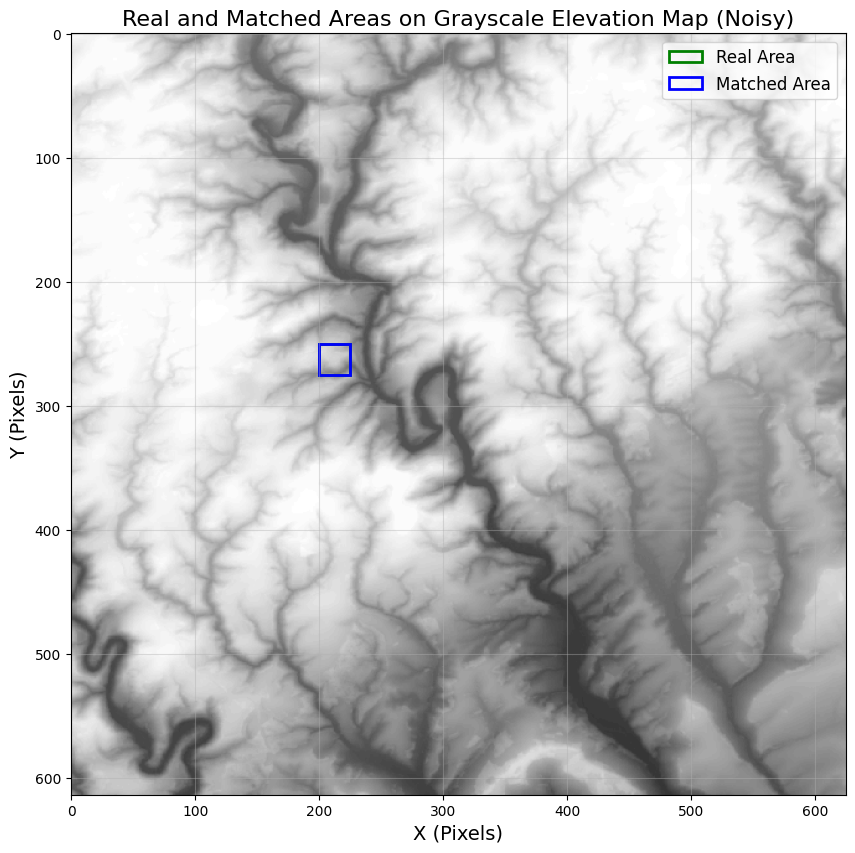

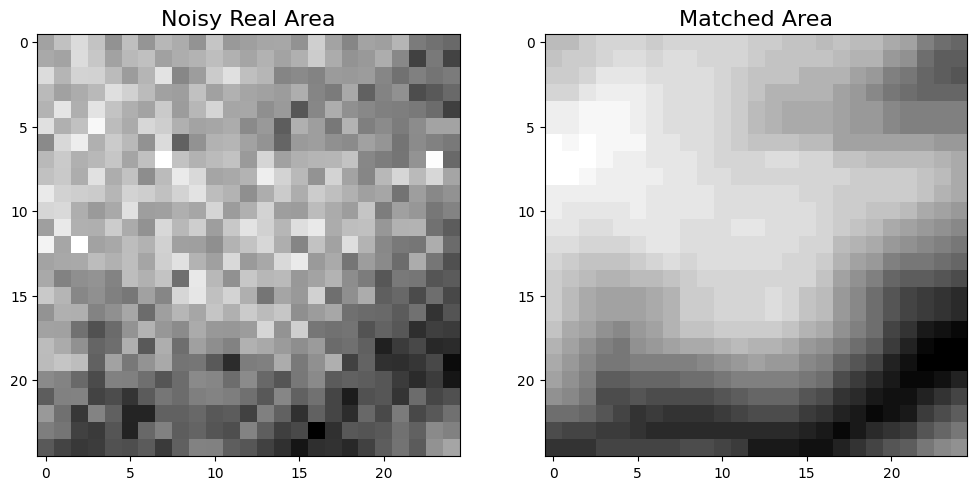

Matched Position (Pixels): (250, 200)
Best SSIM Score with Noise: 0.41176336815314224
Real Area Top-Left (Pixels): (250, 200)


In [10]:
# Integration of SSIM (Structural Similarity Index) Matching into the Notebook

from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale PNG file
def load_png(file_path):
    """
    Loads a grayscale PNG image and converts it into a numpy array.
    """
    image = Image.open(file_path).convert("L")  # Convert to grayscale
    return np.array(image)

# Function to clip a smaller area from the raster
def clip_raster(raster, start_x, start_y, width, height):
    """
    Clips a rectangular region from a raster.
    """
    return raster[start_y:start_y + height, start_x:start_x + width]

from skimage.util import view_as_windows
import numpy as np

def ssim_matching_fast(large_raster, small_raster):
    """
    Optimized SSIM matching using vectorized operations.
    """
    height, width = small_raster.shape

    # Create sliding windows on the large raster
    windows = view_as_windows(large_raster, (height, width))

    # Pre-compute statistics for the small raster
    small_mean = np.mean(small_raster)
    small_std = np.std(small_raster)

    # Compute SSIM for each sliding window
    best_score = -float("inf")
    best_position = None

    for y in range(windows.shape[0]):
        for x in range(windows.shape[1]):
            patch = windows[y, x, :, :]
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)
            score = ssim(patch, small_raster, data_range=patch.max() - patch.min())
            if score > best_score:
                best_score = score
                best_position = (y, x)

    return best_position, best_score

# Downsample large raster for faster matching
def downsample_raster(raster, factor):
    """
    Downsample a raster by a given factor.
    """
    return raster[::factor, ::factor]

def multi_resolution_ssim_matching(large_raster, small_raster, downsample_factor=4):
    """
    Multi-resolution SSIM matching with downsampling and refinement.
    """
    height, width = small_raster.shape

    # Step 1: Downsample the rasters
    large_raster_ds = downsample_raster(large_raster, downsample_factor)
    small_raster_ds = downsample_raster(small_raster, downsample_factor)

    # Step 2: Perform SSIM matching on downsampled rasters
    downsampled_position, _ = ssim_matching_fast(large_raster_ds, small_raster_ds)

    # Step 3: Refine the match on full resolution
    refined_y = downsampled_position[0] * downsample_factor
    refined_x = downsampled_position[1] * downsample_factor

    # Define search region bounds
    search_window_size_y = max(height + 20, 100)  # Ensure it's larger than small_raster
    search_window_size_x = max(width + 20, 100)

    # Ensure search region stays within bounds of the large raster
    search_start_y = max(0, refined_y - search_window_size_y // 2)
    search_start_x = max(0, refined_x - search_window_size_x // 2)
    search_end_y = min(large_raster.shape[0], search_start_y + search_window_size_y)
    search_end_x = min(large_raster.shape[1], search_start_x + search_window_size_x)

    # Extract search region
    search_region = large_raster[search_start_y:search_end_y, search_start_x:search_end_x]

    # Perform refined matching in the search region
    refined_position, best_score = ssim_matching_fast(search_region, small_raster)

    # Adjust to global coordinates
    final_y = search_start_y + refined_position[0]
    final_x = search_start_x + refined_position[1]

    return (final_y, final_x), best_score



large_raster = load_png(file_path)

# Define the real area (e.g., where the drone observes)
clip_start_x, clip_start_y = 200, 250  # Starting position in pixels
clip_width, clip_height = 25, 25  # Dimensions of the clipped area
real_area = clip_raster(large_raster, clip_start_x, clip_start_y, clip_width, clip_height)

# Function to add noise to the smaller area
def add_noise_to_raster(raster, noise_level=10):
    """
    Adds random Gaussian noise to a raster.
    :param raster: Input raster to which noise will be added.
    :param noise_level: Standard deviation of the Gaussian noise.
    :return: Raster with added noise.
    """
    noise = np.random.normal(0, noise_level, raster.shape)
    noisy_raster = raster + noise
    noisy_raster = np.clip(noisy_raster, 0, 255)  # Clip values to stay in grayscale range
    return noisy_raster

# Add noise to the smaller area (real_area)
noise_level = 5  # Adjust noise level as needed
real_area_noisy = add_noise_to_raster(real_area, noise_level)

# Perform multi-resolution SSIM matching with the noisy smaller area
matched_position, best_score = multi_resolution_ssim_matching(large_raster, real_area_noisy, downsample_factor=4)

# Visualize the real and matched areas
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(large_raster, cmap="gray", alpha=0.8)
ax.set_title("Real and Matched Areas on Grayscale Elevation Map (Noisy)", fontsize=16)

# Plot the real area
rect_real = plt.Rectangle(
    (clip_start_x, clip_start_y),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="green", facecolor="none", linewidth=2, label="Real Area"
)
ax.add_patch(rect_real)

# Plot the matched area
rect_matched = plt.Rectangle(
    (matched_position[1], matched_position[0]),  # Bottom-left corner of the rectangle
    clip_width, clip_height,  # Rectangle dimensions
    edgecolor="blue", facecolor="none", linewidth=2, label="Matched Area"
)
ax.add_patch(rect_matched)

# Add legend and labels
plt.legend(fontsize=12)
ax.set_xlabel("X (Pixels)", fontsize=14)
ax.set_ylabel("Y (Pixels)", fontsize=14)
plt.grid(alpha=0.4)
plt.show()

# Display the noisy real area and matched area
matched_area = clip_raster(large_raster, matched_position[1], matched_position[0], clip_width, clip_height)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(real_area_noisy, cmap="gray")
axes[0].set_title("Noisy Real Area", fontsize=16)
axes[1].imshow(matched_area, cmap="gray")
axes[1].set_title("Matched Area", fontsize=16)
plt.show()

# Print match results
print("Matched Position (Pixels):", matched_position)
print("Best SSIM Score with Noise:", best_score)
print("Real Area Top-Left (Pixels):", (clip_start_y, clip_start_x))

